In [392]:
#!pip install yfinance
#!pip install pytickersymbols
#!pip install finta

In [393]:
from finta import TA
import yfinance
import os
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from tqdm.notebook import tqdm
from time import sleep
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR

In [394]:
percentage = .03

BB_bands = 2.5
BB_periods = 20

rsi = 15
rsi_periods = 14
so = 15 #Stochastic Oscillator: de literatura 20
tsi = 15
mfi = 15 #Money Flow Index, de acuerdo a literatura 20
mi = 27 #Mass index, de acuerdo a literatura 27, aunque depende mucho de cada acción
ke = 0.3 #Kaufmann ratio, de literatura: si sube o baja de +- 30 indica una fuerza en el trend (que debería regresar)
uo = 20 #Ultimate Oscillator, de literatura: límites de 30 y 70 para overbought y oversold

In [395]:
sp500_url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500, *_=pd.read_html(sp500_url)
sample = sp500#.head(1)#.reset_index()#[['Symbol','GICS Sector', 'GICS Sub-Industry']]

sample

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [396]:
#PARA PRUEBA DE STOCK INDIVIDUAL

# ticker_df = yfinance.download('VNT',period='1Y')[['Close', 'Volume']].rename({"Close":f"close",
#                                                                            "Volume":f"volume"},axis=1)
# ticker_df['V_change'] = (ticker_df['volume'] / ticker_df['volume'].shift(1)) - 1
# ticker_df

In [ ]:
ix=0
df=pd.DataFrame()
df_volume = pd.DataFrame()
for i in tqdm(range(len(sample))):
  ticker_df = yfinance.download(sample.Symbol[i],period='5Y')[['Open','Close', 'Low', 'High', 'Volume']]#.rename({"Close":f"close_{sample.Symbol[i]}",
                                                                                           #'Volume':f'volume_{sample.Symbol[i]}'},axis=1)
  if len(ticker_df) != 0:
    ticker_df['V_change'] = (ticker_df['Volume'] / ticker_df['Volume'].shift(1)) - 1
    ticker_df['Ticker'] = sample.Symbol[i]
    ticker_df['%'] = (ticker_df['Open'] - ticker_df['Close'].shift(1)) / ticker_df['Close'].shift(1)
    ticker_df['GU'] = 0
    ticker_df['GD'] = 0
  
    for j in range(len(ticker_df)):
      if ticker_df['%'][j] > percentage:
        ticker_df['GU'][j] = True
      elif ticker_df['%'][j] < -percentage:
        ticker_df['GD'][j] = True

    ticker_df['UB'] = ticker_df['Close'].rolling(20).mean() + ticker_df['Close'].rolling(20).std() * BB_bands
    ticker_df['LB'] = ticker_df['Close'].rolling(20).mean() - ticker_df['Close'].rolling(20).std() * BB_bands
    # ticker_df['10_MA'] = ticker_df['Close'].rolling(10).mean()
    # ticker_df['20_MA'] = ticker_df['Close'].rolling(20).mean()
    # ticker_df['50_MA'] = ticker_df['Close'].rolling(50).mean()
    # ticker_df['100_MA'] = ticker_df['Close'].rolling(100).mean()
    
    #CACULO DE RSI 
    up, down = ticker_df['Close'].diff().copy(), ticker_df['Close'].diff().copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.ewm(com=(14 - 1), min_periods=14).mean()
    roll_down = down.abs().ewm(com=(14 - 1), min_periods=14).mean()

    RS = roll_up / roll_down
    ticker_df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    #CALCULO DE MACD
    exp12 = ticker_df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = ticker_df['Close'].ewm(span=26, adjust=False).mean()
    ticker_df['MACD'] = exp12 - exp26
    ticker_df['Signal MACD'] = ticker_df['MACD'].ewm(span=9, adjust=False).mean()
    ticker_df['MACD_B_S'] = ticker_df['MACD'] > ticker_df['Signal MACD'] #0: Sell, 1: Buy
    
    #CALCULO STOCHASTCI OSCILLATOR
    L14 = ticker_df['Low'].rolling(window=14).min()
    H14 = ticker_df['High'].rolling(window=14).max()
    ticker_df['%K'] = 100*((ticker_df['Close'] - L14) / (H14 - L14) )
    ticker_df['%D'] = ticker_df['%K'].rolling(window=3).mean()

    #COMBINACION DE PRIZE ZONE OSCILLATOR (PZO) Y AVERAGE DIRECTIONAL INDEX (ADX):
    #Condiciones para Buy (baja el -60 en trend)
    pzo = TA.PZO(ticker_df)
    adx = TA.ADX(ticker_df)
    ticker_df['PZO_ADX'] = ((pzo < -60) & (pzo.shift(1) >= -60) & (adx > 18)) | ((pzo > 15) & (pzo.shift(1) <= 15) & (adx < 18)) 
    
    #TRUE STRENGHT INDEX:
    tsindex = TA.TSI(ticker_df)
    ticker_df['TSI_H'] = tsindex.TSI > tsi
    ticker_df['TSI_L'] = tsindex.TSI < -tsi

    #MONEY FLOW INDEX:
    mfindex = TA.MFI(ticker_df)
    ticker_df['MFI_H'] = mfindex > 100 - mfi
    ticker_df['MFI_L'] = mfindex < mfi

    #MASS INDEX:
    mindex = TA.MI(ticker_df)
    ticker_df['MI'] = mindex > mi

    #KAUFMAN EFFICIENCY RATIO
    keratio = TA.ER(ticker_df)
    ticker_df['KE_L'] = keratio < ke

    #ULTIMATE OSCILLATOR
    uoscillator = TA.UO(ticker_df)
    ticker_df['UO_L'] = uoscillator < uo

    #TARGET: 0 o 1 si el día siguiente cerró abajo (0) o arriba (1)
    ticker_df['y'] = (ticker_df['Close'] < ticker_df['Close'].shift(-1)) * 1 #El Close siguiente arriba del Close de hoy 
    #ticker_df['y'] = (ticker_df['Open'].shift(-1) < ticker_df['Close'].shift(-1)) * 1  #El día siguiente es green
    ticker_df = ticker_df.dropna() 
    ticker_df = ticker_df.loc[(ticker_df.index < '2020-02-01') | (ticker_df.index > '2020-04-01')]

    df = pd.concat([df,ticker_df])
  # df.insert(i, f'close_{sample.Symbol[i]}',ticker_df[f'close_{sample.Symbol[i]}'])
  # df_volume.insert(i, f'volume_{sample.Symbol[i]}',ticker_df[f'volume_{sample.Symbol[i]}'])

In [398]:
#pzo.loc['2012-05-10':'2012-05-25']

In [ ]:
df_ml = df[['Close', 'Ticker', 'V_change', 'GU', 'GD', 'PZO_ADX', 'TSI_H', 'TSI_L','MFI_H', 'MFI_L', 'MI', 'KE_L', 'UO_L', 'y']]
df_ml['UB'] = df['Close'] > df['UB']
df_ml['LB'] = df['Close'] < df['LB']
# df_ml['10_MA'] = df['Close'] > df['10_MA']
# df_ml['20_MA'] = df['Close'] > df['20_MA']
# df_ml['50_MA'] = df['Close'] > df['50_MA']
# df_ml['100_MA'] = df['Close'] > df['100_MA']
df_ml['RSI_H'] = df['RSI'] > 100 - rsi
df_ml['RSI_L'] = df['RSI'] < rsi
df_ml['MACD_cross'] = (df['MACD_B_S'] - df['MACD_B_S'].shift(1)) != 0 #1 si el signal cruza el MACD
df_ml['SO_H'] = (df['%K'] > 100 - so) & (df['%D'] > 100 - so)
df_ml['SO_L'] = (df['%K'] < so) & (df['%D'] < so)

df_ml = df_ml*1
df_ml = df_ml[~df_ml.isin([np.nan, np.inf, -np.inf]).any(1)]

In [400]:
df_ml

,Close,Ticker,V_change,GU,GD,PZO_ADX,TSI_H,TSI_L,MFI_H,MFI_L,MI,KE_L,UO_L,y,UB,LB,RSI_H,RSI_L,MACD_cross,SO_H,SO_L
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-29,167.380005,MMM,0.185230,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2016-05-02,168.339996,MMM,-0.133031,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-05-03,167.970001,MMM,0.130506,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-05-04,167.160004,MMM,0.101914,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2016-05-05,167.770004,MMM,-0.206742,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,156.149994,ZTS,0.133164,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2021-03-29,158.389999,ZTS,0.089282,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-30,157.039993,ZTS,-0.365219,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [401]:
# df_ml_gapup = df_ml[#(df_ml['V_change'] > 0) & 
#                     (df_ml['GD'] == 1) 
#                     & (df_ml['LB'] == 1) 
#                     #& (df_ml['RSI_L'] == 1) 
#                     #& (df_ml['SO_L'] == 1)
#                     #& (df_ml['TSI_L'] == 1)
#                     #& (df_ml['MFI_L'] == 1)
#                     & (df_ml['MI'] == 1)
#                     #& (df_ml['KE_L'] == 1)
#                     #& (df_ml['UO_L'] == 1)
#                     #& (df_ml['PZO_ADX'] == 1)
#                     ]

# print(df_ml_gapup['y'].value_counts())

# #Porcentaje de reversal correctos:
# len(df_ml_gapup[df_ml_gapup['y']==1]) / df_ml_gapup['y'].count()

#[0, 'LB', 0, 0, 'TSI_L', 'MFI_L', 'MI', 'KE_L']

In [ ]:
import itertools

nombres = ['GD', 'LB', 'RSI_L', 'SO_L', 'TSI_L', 'MFI_L', 'MI', 'KE_L', 'UO_L']

n = len(nombres)
#lst = list(itertools.product([0, 1], repeat=n)) #Tupla
lst = list(map(list, itertools.product([0, 1], repeat=n))) #Lista de listas

new_list = []
for element in lst:
  new_element = []
  for j in range(len(element)):
    if element[j] == 0:
      new_element.append(0)
    else:
      new_element.append(nombres[j])
  new_list.append(new_element)


totales = pd.DataFrame([])
efectividad = []
green = []
red = []
trade_day = []
combinacion = []
for element in new_list:
  string = ''
  for j in range(len(element)):
    if len(string) != 0 and element[j] != 0:
      string += ' & '
    if element[j] != 0:
      string += '(df_ml["' + element[j] + '"] == 1)'

  if len(string) != 0:
    df_ml_total = df_ml[eval(string)]

    efectividad.append(len(df_ml_total[df_ml_total['y']==1]) / df_ml_total['y'].count())

    if len(df_ml_total['y'].value_counts()) == 2:
      green.append(df_ml_total['y'].value_counts()[1])
    else:
      green.append(0)

    if len(df_ml_total['y'].value_counts()) == 2:
      red.append(df_ml_total['y'].value_counts()[0])
    else:
      red.append(0)
    
    trade_day.append(df_ml_total['y'].count()/len(ticker_df))
    combinacion.append(element)

totales.insert(0,'Efectividad', efectividad)
totales.insert(1,'Green', green)
totales.insert(2,'Red', red)
totales.insert(3, 'Trade/Day', trade_day)
totales.insert(4,'Combinación', combinacion)

In [403]:
#Totales, ordenado por la mayor Efectividad y un filtro para elegir un mínimo de Trade/Day, por ejemplo

totales[totales['Trade/Day'] >= 0.1].sort_values(by='Efectividad', ascending=False).head(10)

,Efectividad,Green,Red,Trade/Day,Combinación
131,0.742739,179,62,0.201169,"[0, LB, 0, 0, 0, 0, MI, 0, 0]"
11,0.602484,97,64,0.134391,"[0, 0, 0, 0, 0, MFI_L, MI, 0, 0]"
35,0.599658,701,468,0.975793,"[0, 0, 0, SO_L, 0, 0, MI, 0, 0]"
51,0.598837,515,345,0.717863,"[0, 0, 0, SO_L, TSI_L, 0, MI, 0, 0]"
19,0.590008,2976,2068,4.210351,"[0, 0, 0, 0, TSI_L, 0, MI, 0, 0]"
21,0.589680,1417,986,2.005843,"[0, 0, 0, 0, TSI_L, 0, MI, KE_L, 0]"
37,0.588235,80,56,0.113523,"[0, 0, 0, SO_L, 0, 0, MI, KE_L, 0]"
27,0.586667,88,62,0.125209,"[0, 0, 0, 0, TSI_L, MFI_L, MI, 0, 0]"
5,0.581537,5046,3631,7.242905,"[0, 0, 0, 0, 0, 0, MI, KE_L, 0]"
3,0.567737,9622,7326,14.146912,"[0, 0, 0, 0, 0, 0, MI, 0, 0]"


In [ ]:
# Analisis de profit en backtest

cash = 7500 #Cash por trade

df_profit = df_ml[['Ticker', 'Close', 'LB', 'MI', 'y']]
df_profit['#_Shares'] = 0
df_profit['PL'] = 0.0

for i in range(len(df_profit)):
  if df_profit['LB'][i] == True and df_profit['MI'][i] == True: #and df_profit['SO_L'][i] == True and df_profit['RSI_L'][i] == True:
    df_profit['#_Shares'][i] = cash // df_profit['Close'][i]
    df_profit['PL'][i] = df_profit['#_Shares'][i] * (df_profit['Close'][i+1] - df_profit['Close'][i]) 

In [408]:
df_profit[(df_profit['PL'] != 0)]#.loc['2018'] #[(df_profit['Ticker'] == 'MMM')].loc['2020-03-13':'2020-03-17'] #(df_profit['PL'] != 0) & 

,Ticker,Close,LB,MI,y,#_Shares,PL
Date,,,,,,,
2018-02-08,MMM,222.889999,1,1,1,33,76.560242
2020-09-24,ACN,214.419998,1,1,1,34,7.140228
2020-09-25,ACN,214.630005,1,1,1,34,277.099792
2018-02-08,ADBE,185.160004,1,1,1,40,113.200073
2018-02-08,A,65.050003,1,1,1,115,221.950035
...,...,...,...,...,...,...,...
2017-08-01,WST,87.800003,1,1,0,85,-36.550026
2018-10-25,WST,104.349998,1,1,0,71,-228.620087
2018-10-26,WST,101.129997,1,1,1,74,14.060181


In [ ]:
#df_profit[(df_profit['PL'] != 0)].loc['2020-5-15'] 

In [409]:
df_to_plot = df_profit.groupby(df_profit.index).agg({'PL':sum})
df_to_plot.sum()

PL    18892.668562
dtype: float64

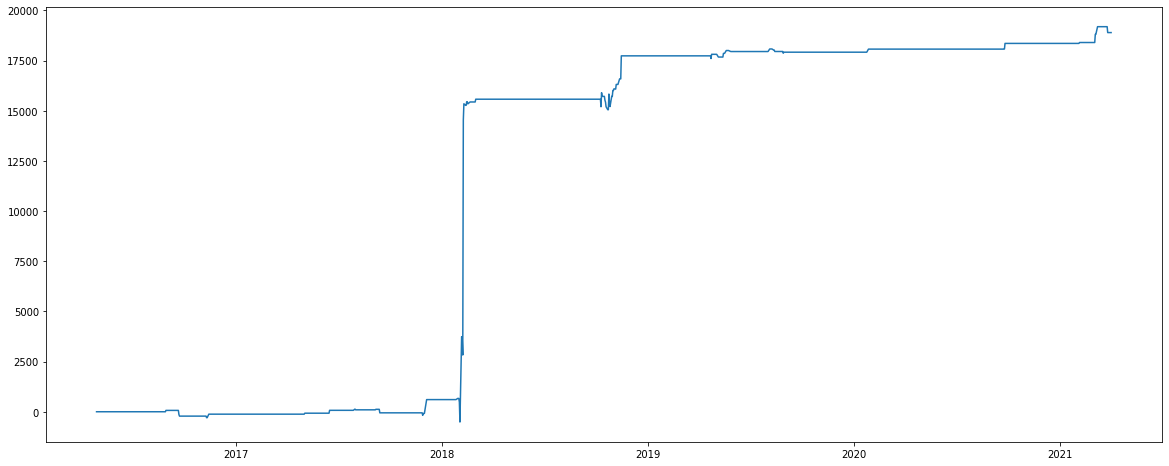

In [410]:
plt.figure(figsize=(20,8))
plt.plot(df_to_plot.cumsum())